In [1]:
# this is necessary if using a module with external functions, in this case if file will be modified, functions will reload.
%load_ext autoreload
%autoreload 2

import numpy as np
import kwant
%run matplotlib_setup.ipy
from matplotlib import pyplot
import aux_funcs
from kwant.digest import uniform    # a (deterministic) pseudorandom number generator
from types import SimpleNamespace
import copy
from cmath import exp

In [2]:
lat = kwant.lattice.square(norbs=1)

In [63]:
def make_wire(W=10, L=5, t=1):
    
    # bulk disorder
    def onsite(site, params):
        return params.U0 * (uniform(repr(site), repr(params.salt)) - 0.5) + 4 * t
    
    # walls roughness (disorder)
    def on_edge(site, params):
        return  params.Uw * (uniform(repr(site), repr(params.salt)) - 0.5) + 4 * t

    # magnetic field
    def hopping(site_i, site_j, params):
        xi, yi = site_i.pos
        xj, yj = site_j.pos  
        return -t*exp(-0.5j * params.phi * (xi - xj) * (yi + yj))
    
    # Construct the scattering region.
    sr = kwant.Builder()
    sr[(lat(x, y) for x in range(L) for y in range(W))] = onsite
    sr[lat.neighbors()] = hopping
    
    # make walls rough
    for site in aux_funcs.edges(sr, lat):
        sr[site] = on_edge
        
    
    # Build and attach lead from both sides.
    lead = kwant.Builder(kwant.TranslationalSymmetry([-1,0]))
    lead[(lat(0,y) for y in range(W))] = 4*t
    lead[lat.neighbors()] = hopping
    
    sr.attach_lead(lead)
    sr.attach_lead(lead.reversed())

    return sr

# scaling with width for rough walls

we plot the transmission for diffenrent wall thicknesses for both bulk disorder and surface disorder.

In [91]:
def calc_surface_disorder(Uw, U0, W, L, energy, salt = 12):
    params = SimpleNamespace(Uw = Uw, U0 = U0, phi = 0, salt = salt)
    wire = make_wire(W, L).finalized()
    smat = kwant.smatrix(wire, energy, args=[params])
    return smat.transmission(1,0)
        

## dependence on wall roughness

we quantify wall roughness using the on-site potential along the walls, Uw.

In [100]:
UwVec = np.linspace(0,30,10)
Nruns = 10
transfull = np.zeros((len(UwVec), Nruns))
for i in range(Nruns):
    print('i = ',i)
    for j in range(len(UwVec)):
        transfull[j,i] = calc_surface_disorder(UwVec[j], 0, 80, 300, 1, np.random.randint(100000))
transmean_Uw = transfull.mean(axis=1)/W

i =  0
i =  1
i =  2
i =  3
i =  4
i =  5
i =  6
i =  7
i =  8
i =  9


In [128]:
pyplot.plot(UwVec, 1./transmean_Uw, '+')
pyplot.title('Scaling of 1/T with wall disorder')
pyplot.xlabel('Uw'); pyplot.ylabel('1/T');

NameError: name 'transmean_Uw' is not defined

## dependence on length

In [122]:
Lvec = range(300,800,50)
Nruns = 10
transfull = np.zeros((len(Lvec), Nruns))
for i in range(Nruns):
    print('i = ',i)
    for j in range(len(Lvec)):
        transfull[j,i] = calc_surface_disorder(5, 0, 150, Lvec[j], 1, np.random.randint(100000))
transmean_L = transfull.mean(axis=1)

i =  0
i =  1
i =  2
i =  3
i =  4
i =  5
i =  6
i =  7
i =  8
i =  9


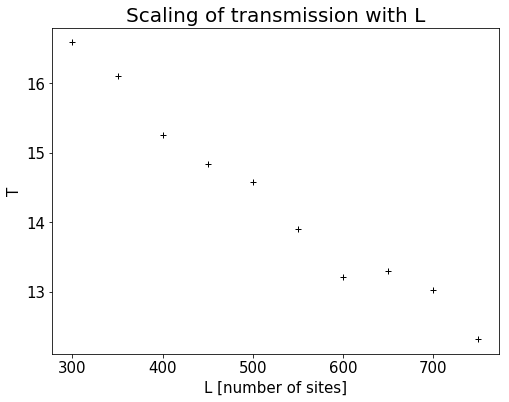

In [127]:
pyplot.plot(Lvec, transmean_L, '+');
pyplot.title('Scaling of transmission with L')
pyplot.xlabel('L [number of sites]'); pyplot.ylabel('T');

it looks like we're not getting the correct scaling for L. Let's see what it looks like with bulk disorder.

In [126]:
Lvec = range(300,800,50)
Nruns = 10
transfull = np.zeros((len(Lvec), Nruns))
for i in range(Nruns):
    print('i = ',i)
    for j in range(len(Lvec)):
        transfull[j,i] = calc_surface_disorder(0, 1, 150, Lvec[j], 1, np.random.randint(100000))
transmean_L_bulk = transfull.mean(axis=1)

i =  0
i =  1
i =  2
i =  3
i =  4
i =  5
i =  6
i =  7
i =  8
i =  9


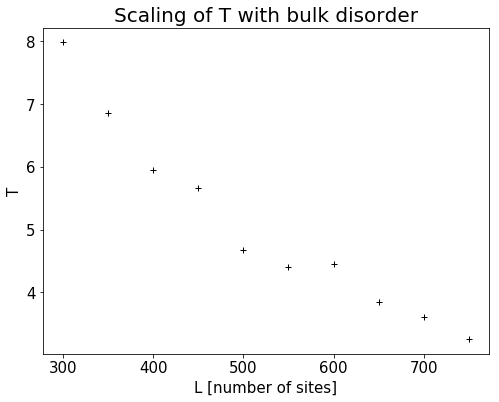

In [129]:
pyplot.plot(Lvec, transmean_L_bulk, '+')
pyplot.title('Scaling of T with bulk disorder')
pyplot.xlabel('L [number of sites]'); pyplot.ylabel('T');

## dependence on energy

In [ ]:
en_vec = np.linspace(0.1,2,0.2)
Nruns = 10
transfull = np.zeros((len(en_vec), Nruns))
for i in range(Nruns):
    print('i = ',i)
    for j in range(len(en_vec)):
        transfull[j,i] = calc_surface_disorder(5, 0, 100, 500, en_vec[j], np.random.randint(100000))
transmean_en = transfull.mean(axis=1)

In [ ]:
pyplot.plot(en_vec, transmean_en, '+');
pyplot.xlabel('E'); pyplot.ylabel('T');

## dependence on width

we pick Uw = 5

In [109]:
Wvec = np.linspace(50,200,25)
WvecWvec

SyntaxError: invalid syntax (<ipython-input-109-cbffa70701e3>, line 2)

In [111]:
Wvec = range(50,200,25)
Nruns = 20
transfull = np.zeros((len(Wvec), Nruns))
for i in range(Nruns):
    print('i = ',i)
    for j in range(len(Wvec)):
        transfull[j,i] = calc_surface_disorder(5, 0, Wvec[j], 300, 1, np.random.randint(100000))
transmean = transfull.mean(axis=1)

i =  0
i =  1
i =  2
i =  3
i =  4
i =  5
i =  6
i =  7
i =  8
i =  9
i =  10
i =  11
i =  12
i =  13
i =  14
i =  15
i =  16
i =  17
i =  18
i =  19


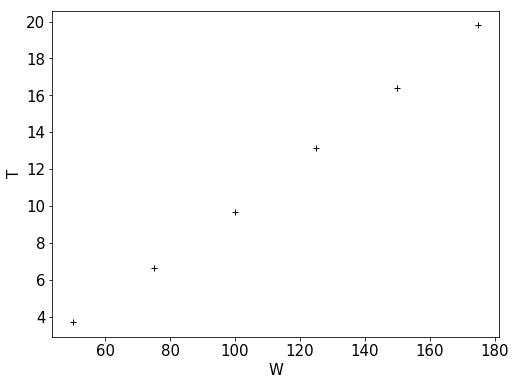

In [113]:

pyplot.plot(Wvec, transmean, '+')
pyplot.xlabel('W'); pyplot.ylabel('T');

it looks like the dependence on W is completely linear! This is not what we expected...

In [64]:
def plot_wavefunction(syst, energy, lead, Uw, U0, phi):
    params = SimpleNamespace(Uw=Uw, U0=U0, phi=phi, salt=12);
    wfs = kwant.wave_function(syst, energy, args=[params])
    density = np.sum(abs(wfs(lead))**2, axis=0)
    kwant.plotter.map(syst, density)
    

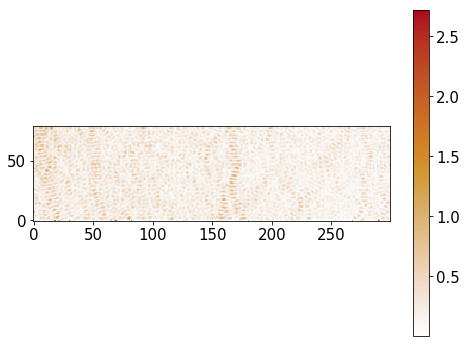

In [108]:
plot_wavefunction(make_wire(80, 300).finalized(), 1, lead = 0, Uw = 10, U0 = 0, phi = 0)

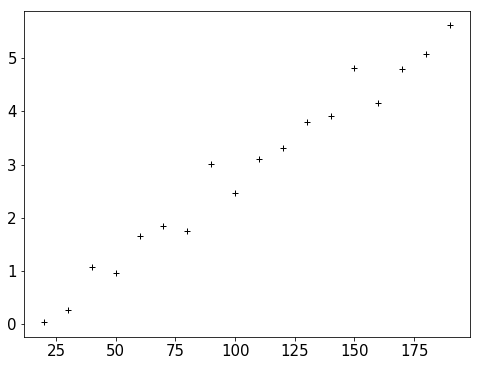

In [70]:
Wvec = range(20, 200, 10)
trans = calc_surface_disorder(0, 1, Wvec, 600, 1, np.random.randint(100000))
pyplot.plot(Wvec, trans, '+');

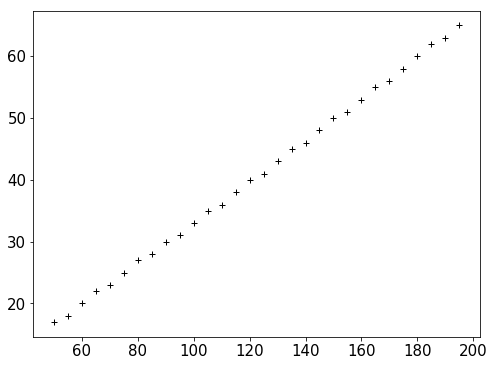

In [71]:
Wvec = range(50, 200, 5)
trans = calc_surface_disorder(0, 0, Wvec, 600, 1, np.random.randint(100000))
pyplot.plot(Wvec, trans, '+');